# VAE Latent Space Exploration

Interactive notebook for exploring the learned latent space of the VAE model.

In [2]:
import sys
sys.path.append('..')

import torch
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, FloatSlider, IntSlider, Dropdown
import yaml

from src.models.vae import VAE
from src.dataset.mnist_loader import MNISTDataset, get_mnist_dataloader
from src.utils.interpolation import create_interpolation_path
from src.utils.visualization import tensor_to_image, plot_latent_space

plt.style.use('seaborn-v0_8-darkgrid')

## Load Model and Configuration

In [3]:
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = VAE(
    latent_dim=config['model']['latent_dim'],
    encoder_channels=config['model']['encoder_channels'],
    decoder_channels=config['model']['decoder_channels']
).to(device)

checkpoint_path = '../outputs/checkpoints/best_model.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded model from epoch {checkpoint['epoch']}")
print(f"Latent dimension: {model.latent_dim}")

Using device: cuda
Loaded model from epoch 1
Latent dimension: 20


## 1. Latent Space Visualization (2D only)

In [4]:
if model.latent_dim == 2:
    test_loader = get_mnist_dataloader(batch_size=256, train=False)
    plot_latent_space(model, test_loader, 'latent_space_2d.png', device, num_batches=20)
    
    from IPython.display import Image
    Image('latent_space_2d.png')
else:
    print(f"Latent space is {model.latent_dim}D, skipping 2D visualization")

Latent space is 20D, skipping 2D visualization


## 2. Interactive Latent Space Decoder

Too many dimensions for interactive sliders. Using random sampling instead.


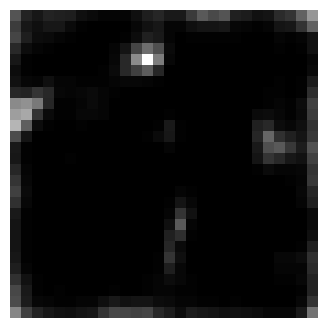

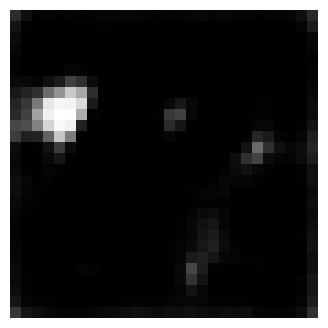

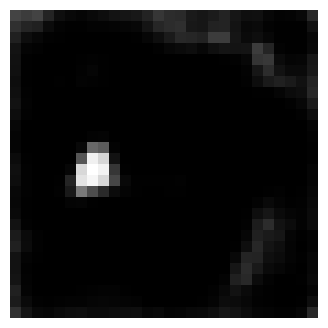

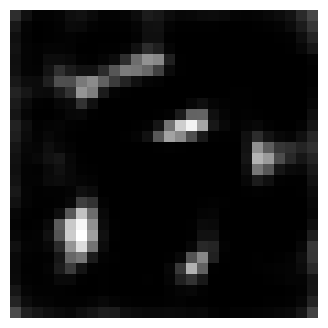

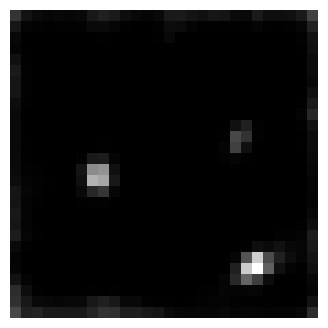

In [5]:
def decode_latent_vector(z_values):
    z = torch.tensor(z_values, dtype=torch.float32).unsqueeze(0).to(device)
    
    with torch.no_grad():
        decoded = model.decode(z)
    
    img = tensor_to_image(decoded[0])
    
    plt.figure(figsize=(4, 4))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f'Decoded from latent vector')
    plt.show()

if model.latent_dim <= 10:
    sliders = [FloatSlider(min=-3, max=3, step=0.1, value=0, description=f'z{i}') 
               for i in range(model.latent_dim)]
    
    def interactive_decode(**kwargs):
        z_values = [kwargs[f'z{i}'] for i in range(model.latent_dim)]
        decode_latent_vector(z_values)
    
    interact(interactive_decode, **{f'z{i}': slider for i, slider in enumerate(sliders)})
else:
    print("Too many dimensions for interactive sliders. Using random sampling instead.")
    
    def sample_and_decode():
        z = torch.randn(1, model.latent_dim).to(device)
        with torch.no_grad():
            decoded = model.decode(z)
        img = tensor_to_image(decoded[0])
        plt.figure(figsize=(4, 4))
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.show()
    
    for _ in range(5):
        sample_and_decode()

## 3. Latent Dimension Traversal

In [ ]:
test_dataset = MNISTDataset(train=False)
sample_image = test_dataset[0][0]

def traverse_dimension(dim=0, num_steps=11):
    with torch.no_grad():
        base_z = model.encode(sample_image.unsqueeze(0).to(device))
        
        values = torch.linspace(-3, 3, num_steps)
        images = []
        
        for val in values:
            z = base_z.clone()
            z[0, dim] = val
            img = model.decode(z)
            images.append(img)
    
    fig, axes = plt.subplots(1, num_steps, figsize=(num_steps * 2, 2))
    for i, (ax, img) in enumerate(zip(axes, images)):
        ax.imshow(tensor_to_image(img[0]), cmap='gray')
        ax.axis('off')
        ax.set_title(f'{values[i]:.1f}', fontsize=10)
    
    plt.suptitle(f'Traversing Latent Dimension {dim}', fontsize=14)
    plt.tight_layout()
    plt.show()

interact(traverse_dimension, 
         dim=IntSlider(min=0, max=model.latent_dim-1, value=0, description='Dimension'),
         num_steps=IntSlider(min=5, max=21, value=11, description='Steps'))

100%|██████████| 9.91M/9.91M [00:03<00:00, 2.71MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.92MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.72MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.35MB/s]


interactive(children=(IntSlider(value=0, description='Dimension', max=19), IntSlider(value=11, description='St…

<function __main__.traverse_dimension(dim=0, num_steps=11)>

## 4. Interactive Interpolation

In [7]:
def get_digit_samples():
    samples = {}
    for digit in range(10):
        for i, (img, _, label) in enumerate(test_dataset):
            if label == digit:
                samples[digit] = img
                break
    return samples

digit_samples = get_digit_samples()

def interpolate_digits(start_digit=0, end_digit=9, steps=10, method='linear'):
    start_img = digit_samples[start_digit]
    end_img = digit_samples[end_digit]
    
    interpolated = create_interpolation_path(
        model, start_img, end_img, 
        num_steps=steps, 
        method=method,
        device=device
    )
    
    fig, axes = plt.subplots(2, min(steps, 10), figsize=(min(steps, 10) * 2, 4))
    
    for i in range(min(steps, 10)):
        idx = i * (steps // min(steps, 10))
        axes[0, i].imshow(tensor_to_image(interpolated[idx]), cmap='gray')
        axes[0, i].axis('off')
        
        alpha = idx / (steps - 1)
        axes[1, i].text(0.5, 0.5, f'{alpha:.2f}', 
                       ha='center', va='center', fontsize=12)
        axes[1, i].axis('off')
    
    plt.suptitle(f'Interpolation: {start_digit} → {end_digit}', fontsize=14)
    plt.tight_layout()
    plt.show()

interact(interpolate_digits,
         start_digit=Dropdown(options=list(range(10)), value=3, description='Start'),
         end_digit=Dropdown(options=list(range(10)), value=8, description='End'),
         steps=IntSlider(min=5, max=30, value=10, description='Steps'),
         method=Dropdown(options=['linear', 'spherical'], value='linear', description='Method'))

interactive(children=(Dropdown(description='Start', index=3, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=3),…

<function __main__.interpolate_digits(start_digit=0, end_digit=9, steps=10, method='linear')>

## 5. Random Walk in Latent Space

In [ ]:
def random_walk(start_digit=5, num_steps=10, step_size=0.5):
    start_img = digit_samples[start_digit].unsqueeze(0).to(device)
    
    with torch.no_grad():
        current_z = model.encode(start_img)
        images = [model.decode(current_z)]
        
        for _ in range(num_steps - 1):
            noise = torch.randn_like(current_z) * step_size
            current_z = current_z + noise
            img = model.decode(current_z)
            images.append(img)
    
    fig, axes = plt.subplots(1, num_steps, figsize=(num_steps * 2, 2))
    for i, (ax, img) in enumerate(zip(axes, images)):
        ax.imshow(tensor_to_image(img[0]), cmap='gray')
        ax.axis('off')
        ax.set_title(f'Step {i}', fontsize=10)
    
    plt.suptitle(f'Random Walk from {start_digit} (step size={step_size})', fontsize=14)
    plt.tight_layout()
    plt.show()

interact(random_walk,
         start_digit=Dropdown(options=list(range(10)), value=5, description='Start Digit'),
         num_steps=IntSlider(min=5, max=15, value=10, description='Steps'),
         step_size=FloatSlider(min=0.1, max=2.0, value=0.5, step=0.1, description='Step Size'))

interactive(children=(Dropdown(description='Start Digit', index=5, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), val…

<function __main__.random_walk(start_digit=5, num_steps=10, step_size=0.5)>

## 6. Arithmetic in Latent Space

In [ ]:
def latent_arithmetic(digit_a=3, digit_b=8, digit_c=1, operation='a+b-c'):
    imgs = {
        'a': digit_samples[digit_a].unsqueeze(0).to(device),
        'b': digit_samples[digit_b].unsqueeze(0).to(device),
        'c': digit_samples[digit_c].unsqueeze(0).to(device)
    }
    
    with torch.no_grad():
        z_a = model.encode(imgs['a'])
        z_b = model.encode(imgs['b'])
        z_c = model.encode(imgs['c'])
        
        if operation == 'a+b-c':
            z_result = z_a + z_b - z_c
        elif operation == 'a-b+c':
            z_result = z_a - z_b + z_c
        elif operation == '2a-b':
            z_result = 2 * z_a - z_b
        elif operation == '(a+b)/2':
            z_result = (z_a + z_b) / 2
        
        result_img = model.decode(z_result)
    
    fig, axes = plt.subplots(1, 5, figsize=(10, 2))
    
    axes[0].imshow(tensor_to_image(imgs['a'][0]), cmap='gray')
    axes[0].set_title(f'{digit_a} (a)', fontsize=12)
    axes[0].axis('off')
    
    axes[1].imshow(tensor_to_image(imgs['b'][0]), cmap='gray')
    axes[1].set_title(f'{digit_b} (b)', fontsize=12)
    axes[1].axis('off')
    
    axes[2].imshow(tensor_to_image(imgs['c'][0]), cmap='gray')
    axes[2].set_title(f'{digit_c} (c)', fontsize=12)
    axes[2].axis('off')
    
    axes[3].text(0.5, 0.5, operation, ha='center', va='center', fontsize=14)
    axes[3].axis('off')
    
    axes[4].imshow(tensor_to_image(result_img[0]), cmap='gray')
    axes[4].set_title('Result', fontsize=12)
    axes[4].axis('off')
    
    plt.tight_layout()
    plt.show()

interact(latent_arithmetic,
         digit_a=Dropdown(options=list(range(10)), value=3, description='Digit A'),
         digit_b=Dropdown(options=list(range(10)), value=8, description='Digit B'),
         digit_c=Dropdown(options=list(range(10)), value=1, description='Digit C'),
         operation=Dropdown(options=['a+b-c', 'a-b+c', '2a-b', '(a+b)/2'], 
                          value='a+b-c', description='Operation'))

interactive(children=(Dropdown(description='Digit A', index=3, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=3…

<function __main__.latent_arithmetic(digit_a=3, digit_b=8, digit_c=1, operation='a+b-c')>